# Sequence Tagging: Bidirectional LSTM + CRF
Source: https://www.depends-on-the-definition.com/sequence-tagging-lstm-crf/

In [1]:
import glob, os, csv, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# AUTO-LABELLED DATA SET = TRAIN SET + VALIDATION SET
filename = r"../1-2 OzROCK/Files/OzROCK dataset/BIG_set_byDictionary.txt"
words = []
tags = []
train_sentences = []

with open(filename, 'r') as file :
    currSentence = []
    lines = []
    for line in file:
        cols = line.split(" ") # should be lower-case already
        if line.strip() == '':
            # Reset sentence            
            train_sentences.append(currSentence)
            currSentence = []
        elif len(cols) > 2:
            print(line)
        else:
            currSentence.append([cols[0].strip(), cols[1].strip()])
            words.append(cols[0].strip())
            tags.append(cols[1].strip())
print('Num sentences = ', len(train_sentences)) # 18589; 160,343

train_words = list(set(words))
print('Num words in training set = ', len(train_words))

train_sent_lengths = [len(s) for s in train_sentences]

plt.hist(train_sent_lengths, density=1, bins=1000) # x value is bins
plt.axis([0, 140, 0, 0.1])  # xmin,xmax,ymin,ymax
plt.xlabel('Sentence Length')
plt.ylabel('Percentage of sentences')

plt.show()

Num sentences =  31813
Num words in training set =  24819


<Figure size 640x480 with 1 Axes>

Num lines =  53295
Num test_sentences =  2000
Num test_words =  4910
13


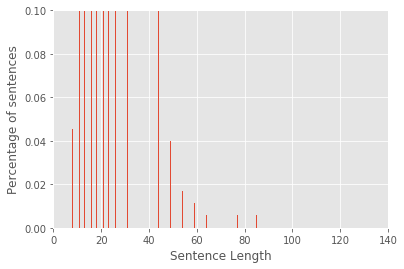

In [2]:
# TEST DATA - manually annotated
file_in = r"../1-2 OzROCK/Files/OzROCK dataset/EvaluationSet_annotated_by_doman_experts.txt" # TestSet_March02
filename_result = r"../1-2 OzROCK/Files/OzROCK dataset/EvaluationSet_trueTag_modelTag.txt" # Evaluation set (expert-annotated) (predicted)

#test_data = pd.read_csv(filename, header = None, delimiter=" ", na_values=['\n'], quoting=csv.QUOTE_NONE, encoding='latin1', skip_blank_lines=True)
#print(test_data.info())
#print(test_data.head(10))
test_words = []
test_tags = []
test_sentences = []
c = 0
with open(file_in, 'r') as file :
    currSentence = []
    lines = []
    file.readline()
    for line in file:
        try:
            c += 1
            cols = line.strip().split(" ")
            if line.strip() == '':
                # Reset sentence            
                test_sentences.append(currSentence)
                currSentence = []
            elif len(cols) > 2:
                print('more than 2 columns: ', line)
            else :
                currSentence.append([cols[0].lower().strip(), cols[1].strip()])            
                test_words.append(cols[0].lower().strip())
                test_tags.append(cols[1].strip())
        except:
            print('error: ', c, line)

test_words = list(set(test_words))
print('Num lines = ', c)
print('Num test_sentences = ', len(test_sentences)) # 18589; 160,343
print('Num test_words = ', len(test_words))

test_sent_lengths = [len(s) for s in test_sentences]
print(test_sent_lengths[0])

plt.hist(test_sent_lengths, density=1, bins=1000) # x value is bins
plt.axis([0, 140, 0, 0.1])  # xmin,xmax,ymin,ymax
plt.xlabel('Sentence Length')
plt.ylabel('Percentage of sentences')

plt.show()

In [3]:
# Word dictionary
words = train_words + test_words
words = list(set(words))
words.append("ENDPAD")

n_words = len(words) # unique words
print("Number of unique words in all data: ", n_words)

tags = list(set(tags))
n_tags = len(tags)
print("\nNumber of unique tags: ", n_tags)
print(tags)

print(len(words))
print(words[:10])

Number of unique words in all data:  25391

Number of unique tags:  13
['B-TIMESCALE', 'B-LOCATION', 'I-ORE_DEPOSIT', 'I-MINERAL', 'I-TIMESCALE', 'B-ROCK', 'B-MINERAL', 'I-LOCATION', 'I-STRAT', 'B-STRAT', 'B-ORE_DEPOSIT', 'O', 'I-ROCK']
25391
['114km2', 'memoir', '1576ma', 'c345_1993_2006a_draft', 'porosity', 'fourteen', 'ivey', 'adobe', 'cove', '4.5.1']


### To encode the character-level information, we will use character embeddings and a LSTM to encode every word to an vector.
We can use anyything that produces a single vector for a sequence of characters that represent a word. (a max-pooling architecture or a CNN)

Then we feed the vector to another LSTM together with the learned word embedding.

In [4]:
max_len = 100 # 75

word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

print(word2idx["gold"]) # id=3818
print(tag2idx["B-MINERAL"]) # id = 9

8356
6


In [5]:
# Map the senctences to a sequence of numbers and then pad the sequence
# We increased the index of the words by one to use zero as a padding value, 
# because we want to use the mask_zero parameter of the embedding layer to ignore inputs with value zero

from keras.preprocessing.sequence import pad_sequences

X = [[word2idx[w[0]] for w in s] for s in train_sentences]

# Pad the sentences
#X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

y = [[tag2idx[w[1]] for w in s] for s in train_sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

Using TensorFlow backend.


In [6]:
#words[0] = 'NaN'
#words[:10]
print(X[0])
print(y[0])

[12155  4770 17731 17748 19160 22125  9297 12766 10318  6470  7254 15550
 21959 14320  7254  4173 21977 25047 11621  3647  3763 25390 25390 25390
 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390
 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390
 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390
 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390
 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390
 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390
 25390 25390 25390 25390]
[11  1 11 11 11 11 11 11  5 12 12 11 11  5 12 11 11 11  5 12 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11]


In [7]:
from keras.utils import to_categorical # Converts a class vector (integers) to binary class matrix.

y = [to_categorical(i, num_classes=n_tags) for i in y]

print(X[0])
print(y[0])

[12155  4770 17731 17748 19160 22125  9297 12766 10318  6470  7254 15550
 21959 14320  7254  4173 21977 25047 11621  3647  3763 25390 25390 25390
 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390
 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390
 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390
 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390
 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390
 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390 25390
 25390 25390 25390 25390]
[[0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [8]:
# We split in train and test set.
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

In [9]:
print(X_tr.shape)
print(len(y_tr))
print(X_te.shape)
print(len(y_te))

(25450, 100)
25450
(6363, 100)
6363


In [10]:
# Now we can fit a LSTM-CRF network with an embedding layer.
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras.utils import plot_model

### Fit a "Bidirectional LSTM + CRF" network with an embedding layer.

In [11]:
input = Input(shape=(max_len,))

#model = Embedding(input_dim=n_words + 1, output_dim=20, input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Embedding(input_dim=n_words + 1, output_dim=64, input_length=max_len, mask_zero=True)(input)  # 64-dim embedding

# ????
#model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.5))(model)  # variational biLSTM
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)  # variational biLSTM

model = TimeDistributed(Dense(100, activation="relu"))(model)  # a dense layer as suggested by neuralNer

crf = CRF(n_tags)  # CRF layer

out = crf(model)  # output

/Users/majiga/anaconda3/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/majiga/anaconda3/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 64)           1625088   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 200)          132000    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 100)          20100     
_________________________________________________________________
crf_1 (CRF)                  (None, 100, 13)           1508      
Total params: 1,778,696
Trainable params: 1,778,696
Non-trainable params: 0
_________________________________________________________________


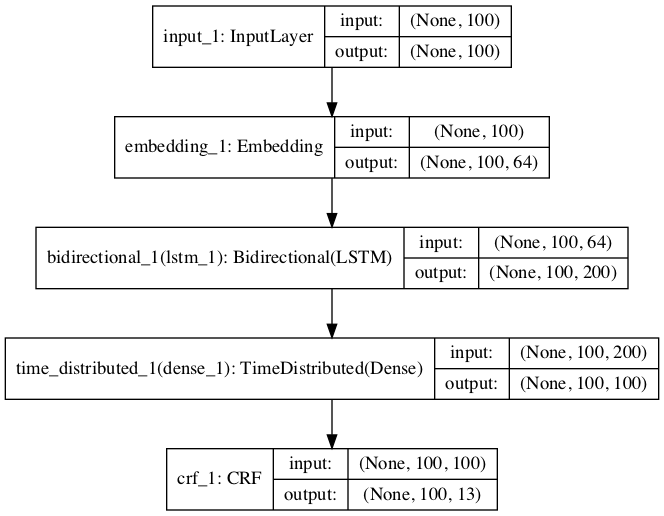

In [12]:
model = Model(input, out)

model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()
plot_model(model, to_file='model1_CRF.png', show_shapes=True, show_layer_names=True)

In [13]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=20, validation_split=0.2, verbose=2)

Train on 20360 samples, validate on 5090 samples
Epoch 1/20
 - 135s - loss: 0.0747 - crf_viterbi_accuracy: 0.9800 - val_loss: 0.0209 - val_crf_viterbi_accuracy: 0.9932
Epoch 2/20
 - 134s - loss: 0.0121 - crf_viterbi_accuracy: 0.9958 - val_loss: 0.0119 - val_crf_viterbi_accuracy: 0.9958
Epoch 3/20
 - 136s - loss: 0.0064 - crf_viterbi_accuracy: 0.9976 - val_loss: 0.0072 - val_crf_viterbi_accuracy: 0.9973
Epoch 4/20
 - 138s - loss: 0.0042 - crf_viterbi_accuracy: 0.9984 - val_loss: 0.0058 - val_crf_viterbi_accuracy: 0.9978
Epoch 5/20
 - 140s - loss: 0.0031 - crf_viterbi_accuracy: 0.9987 - val_loss: 0.0048 - val_crf_viterbi_accuracy: 0.9980
Epoch 6/20
 - 144s - loss: 0.0023 - crf_viterbi_accuracy: 0.9990 - val_loss: 0.0040 - val_crf_viterbi_accuracy: 0.9984
Epoch 7/20
 - 139s - loss: 0.0018 - crf_viterbi_accuracy: 0.9992 - val_loss: 0.0041 - val_crf_viterbi_accuracy: 0.9983
Epoch 8/20
 - 140s - loss: 0.0014 - crf_viterbi_accuracy: 0.9994 - val_loss: 0.0038 - val_crf_viterbi_accuracy: 0.9984

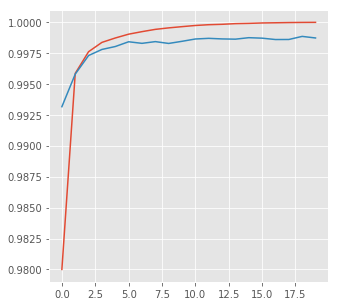

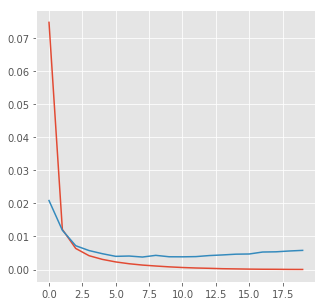

In [14]:
hist = pd.DataFrame(history.history)

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(5,5))
plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])

plt.figure(figsize=(5,5))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

In [15]:
from keras.models import load_model

model.save(r'Files/model_WL_BiLSTM_CRF.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = load_model(r'/Users/majiga/Documents/wamex/datawamex_model.h5')

In [16]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

test_pred = model.predict(X_te, verbose=2)

In [17]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

In [18]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 97.5%


In [19]:
print(classification_report(test_labels, pred_labels, digits=4))

             precision    recall  f1-score   support

    MINERAL     0.9882    0.9887    0.9884      4145
   LOCATION     0.9770    0.9750    0.9760      3915
       ROCK     0.9704    0.9696    0.9700      4837
      STRAT     0.9263    0.9406    0.9334      1043
ORE_DEPOSIT     0.9752    0.9737    0.9745       647
  TIMESCALE     0.9946    0.9946    0.9946       552

avg / total     0.9750    0.9753    0.9752     15139



# Evaluation Set

In [20]:
X_eval = [[word2idx[w[0]] for w in s] for s in test_sentences]

# Pad the sentences
X_eval = pad_sequences(maxlen=max_len, sequences=X_eval, padding="post", value=n_words-1)

y_eval = [[tag2idx[w[1]] for w in s] for s in test_sentences]
y_eval = pad_sequences(maxlen=max_len, sequences=y_eval, padding="post", value=tag2idx["O"])

In [21]:
y_eval = [to_categorical(i, num_classes=n_tags) for i in y_eval]

In [22]:
y_eval_pred = model.predict(X_eval, verbose=2)

In [23]:
y_pred_labels = pred2label(y_eval_pred)
y_labels = pred2label(y_eval)
print("F1-score: {:.2%}".format(f1_score(y_labels, y_pred_labels)))
print(classification_report(y_labels, y_pred_labels, digits=4))

F1-score: 78.52%
             precision    recall  f1-score   support

      STRAT     0.8612    0.7150    0.7813       642
       ROCK     0.7782    0.7819    0.7801      1894
    MINERAL     0.7893    0.9183    0.8489      1297
   LOCATION     0.6241    0.6899    0.6553      1006
ORE_DEPOSIT     0.8795    0.8425    0.8606       381
  TIMESCALE     0.9381    0.9381    0.9381       210

avg / total     0.7754    0.7998    0.7853      5430



In [24]:
#import tensorflow
!python --version

Python 3.6.6 :: Anaconda, Inc.
